In [2]:
import cv2 as cv
from retinaface import RetinaFace
import matplotlib.pyplot as plt
import random
import numpy as np
from sklearn.preprocessing  import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from imutils import build_montages
import face_recognition
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
from sklearn.mixture import GaussianMixture
import math

In [59]:
#USING FACE_RECOGNITION
data=[]
for person_no in range(1,11):
    for image_no in range(1,16):
          path = "face_dataset/" + str(person_no) + "/" + '%03d.jpg'  % image_no
          img = cv.imread(path)
          rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
          boxes = face_recognition.face_locations(rgb,model="cnn")
          encodings = face_recognition.face_encodings(rgb, boxes)
          landmarks = face_recognition.face_landmarks(face_image=rgb, face_locations=boxes)
          # build a dictionary of the image path, bounding box location,
          # and facial encodings and landmarks for the current image
          
          #TO-DO: some images contain multiple faces, somehow need to select just the best one
          #maybe can select the box with biggest area
          if(len(boxes)>1):
            continue

          d = [{"imagePath": path, "loc": box, "encoding": enc, "landmark":landmark} for (box, enc, landmark) in zip(boxes, encodings, landmarks)]
          data.extend(d)

In [ ]:
data = np.array(data)
landmarks = [d["landmark"] for d in data]
#number of faces detected
data.shape

#Examining facial landmark points. We are going to be using these points to normalize the faces

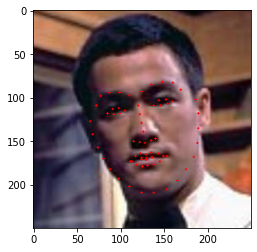

In [61]:
img = cv.imread(data[5]["imagePath"])
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
for key in landmarks[5]:
  for cord in landmarks[5][key]:
    cv.circle(img, cord, 1, (255,0,0), -1)

plt.imshow(img)

#visualising the slope between the eyes

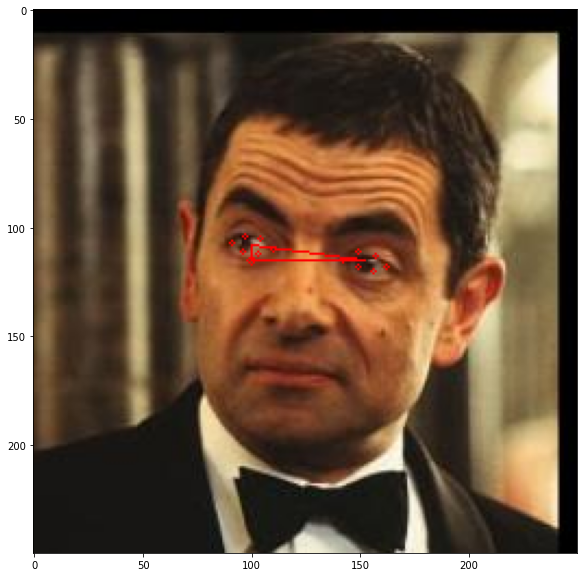

In [62]:
def drawThreePoints(i):
  img = cv.imread(data[i]["imagePath"])
  img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

  for cord in landmarks[i]["right_eye"]:
    cv.circle(img, cord, 1, (255,0,0), 1)
  for cord in landmarks[i]["left_eye"]:
    cv.circle(img, cord, 1, (255,0,0), 1)

  right_eye =  np.asarray(data[i]["landmark"]["right_eye"])
  left_eye = np.asarray(data[i]["landmark"]["left_eye"])
  rightCenter = right_eye.mean(axis=0).astype("int")
  leftCenter = left_eye.mean(axis=0).astype("int")

  if leftCenter[1] > rightCenter[1]:
    thirdPoint = (rightCenter[0], leftCenter[1])
    data[i]["direction"] = 1 #rotate clockwise
  else:
    thirdPoint = (leftCenter[0], rightCenter[1])
    data[i]["direction"] = -1 #counter-clockwise

  cv.circle(img, thirdPoint, 2, (255, 0, 0) , 1)
  cv.line(img,tuple(rightCenter),tuple(leftCenter),(255,0,0),1)
  cv.line(img,tuple(leftCenter),tuple(thirdPoint),(255,0,0),1)
  cv.line(img,tuple(thirdPoint),tuple(rightCenter),(255,0,0),1)

  plt.figure(figsize=(10,10))
  plt.imshow(img)
drawThreePoints(43)

#calculating the angles between two eyes

In [ ]:
for i in range(data.shape[0]):
  right_eye =  np.asarray(data[i]["landmark"]["right_eye"])
  left_eye = np.asarray(data[i]["landmark"]["left_eye"])

  rightCenter = right_eye.mean(axis=0).astype("int")
  leftCenter = left_eye.mean(axis=0).astype("int")

  dy = rightCenter[1] - leftCenter[1]
  dx = rightCenter[0] - leftCenter[0]
  
  slope = dy/dx
  angle = (np.arctan(slope) * 180) / math.pi

  data[i]["angle"] = angle

angles = [d["angle"] for d in data]
plt.hist(angles)

#examining angles histogram 

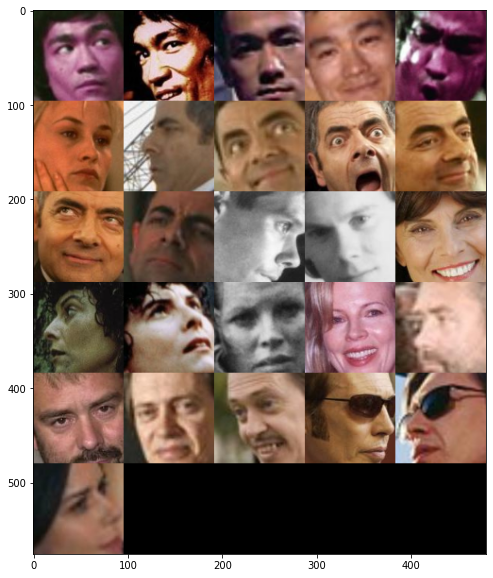

In [64]:
#lets examine where absolute value of angle is over 10
faces=[]
for el in data[np.absolute(angles)>10]:
  img = cv.imread(el["imagePath"])
  (top, right, bottom, left) = el["loc"]
  face = img[top:bottom, left:right]
  face = cv.resize(face, (96, 96))
  face = cv.cvtColor(face, cv.COLOR_BGR2RGB)
  faces.append(face)
montage = build_montages(faces, (96, 96), (5, 6))[0]
plt.figure(figsize=(10,10))
plt.imshow(montage)

#rotate images

In [ ]:
from PIL import Image
for el in data:
  img = cv.imread(el["imagePath"])
  rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
  new_img = Image.fromarray(rgb)
  new_img = np.array(new_img.rotate(el["angle"]))

  #create new encodings for straighter faces
  boxes = face_recognition.face_locations(new_img,model="cnn")
  encodings = face_recognition.face_encodings(new_img,boxes) 
  
  el["encoding_rotated"] = encodings[0]
  plt.figure()
  plt.imshow(new_img)

In [86]:
encodings = [d["encoding"] for d in data]
encodings_rotated = [d["encoding_rotated"] for d in data]


#clustering


In [ ]:
scaler = MinMaxScaler()
#scaler = RobustScaler()
#scaler = StandardScaler()
encodings_norm = scaler.fit_transform(encodings_rotated)

model = KMeans(n_clusters=10, verbose=1, algorithm="elkan", n_init=100)
model.fit(encodings_norm)

labelIDs = np.unique(model.labels_)
numUniqueFaces = len(np.where(labelIDs > -1)[0])
print("[INFO] # unique faces: {}".format(numUniqueFaces))

In [ ]:
 for labelID in labelIDs:
    idxs = np.where(model.labels_ == labelID)[0]
    idxs = np.random.choice(idxs, size=min(25, len(idxs)),replace=False)
    # initialize the list of faces to include in the montage
    faces = []
    for i in idxs:
      # load the input image and extract the face ROI
      image = cv.imread(data[i]["imagePath"])
      (top, right, bottom, left) = data[i]["loc"]
      face = image[top:bottom, left:right]
      face = cv.resize(face, (96, 96))
      face = cv.cvtColor(face, cv.COLOR_BGR2RGB)
      faces.append(face)
    montage = build_montages(faces, (96, 96), (5, 5))[0]
    plt.figure()
    plt.imshow(montage)